#### Load in Data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df = pd.read_csv("merged_health_census_clean.csv")
X = df[['Sleep_Pct', 'Obesity_Pct', 'Asthma_Pct', 'Smoking_Pct',
        'HeartDisease_Pct', 'HighBP_Pct', 'HighChol_Pct']]
y = df['MentalHealth_Pct']



### Evaluation & Validation --> Data Split & CRoss Validation 
Creating a 80/20 train test split and 5 fold cross validation on training data to tune hyper paramters without leakage. CV helps with not dealing with overfittingo n training data.

What is Cross Validation? --> repeats training/testing process many times on differnet parts of datat 
10 Fold Cross Validation 
1. You split your training data into 5 roughly equal parts (“folds”).
2. You train your model on 4 of the folds.
3. You validate it on the 5th fold (the one left out).
4. You repeat this process 5 times, each time leaving out a different fold.
5. Finally, you average the 5 validation scores (like RMSEs).
6. That average is your cross-validated performance estimate.

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


### Hyperparameters --> dials & knobs before training 
--> Lasso : Alpha (how strongly you penalize large coefficients)
--> Randomforest: n_estimators (how many trees to grow), max_depth (how deep each tree can go), min_samples_leaf (minimum # of data pts per leaf), max_featyres (how many features tree can look at)

### Loss Function --> minimize loss, how wrong prediction ares 
- We are using RMSE 

GridSearchCV = “try every combination of hyperparameters with cross-validation,
then pick the best one.”

1. Split the data into folds (like you saw in A3).
2. Train/test the model on each fold for every combination of hyperparameters.
3. Calculate the average RMSE across folds.
4. Pick the settings that produced the lowest RMSE.
5. Refit the best model on all training data.

### Lasso Regression Tuning --> Find ALpha with lowest RMSE 

In [10]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Build pipeline
pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),  # 1scales predictors
    ('model', Lasso(max_iter=10000, random_state=RANDOM_STATE))  #  fits model
])

# Define grid of alpha values to test (logspace from 0.001 to 10)
grid_lasso = {'model__alpha': np.logspace(-3, 1, 15)}

# Run grid search with 10-fold CV
gs_lasso = GridSearchCV(
    pipe_lasso,
    grid_lasso,
    cv=cv,  # ← 10-fold CV object
    scoring='neg_root_mean_squared_error',  # ← minimize RMSE
    n_jobs=-1  # run in parallel for speed
)

gs_lasso.fit(X_train, y_train)
best_lasso = gs_lasso.best_estimator_
print("Best alpha for Lasso:", gs_lasso.best_params_)


Best alpha for Lasso: {'model__alpha': 0.001}


### Random Forest Tuning - best combo of parameters w/ lowest RMSE 

In [11]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

# Grid of hyperparameters to try
grid_rf = {
    'model__n_estimators': [100],  # number of trees (takes super long w longer ones)
    'model__max_depth': [None, 6, 10, 16],  # tree depth
    'model__min_samples_leaf': [1, 2, 5],  # leaf size
    'model__max_features': ['sqrt', 0.5, 1.0]  # number of features per tree
}

gs_rf = GridSearchCV(
    pipe_rf,
    grid_rf,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
print("Best Random Forest params:", gs_rf.best_params_)

Best Random Forest params: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}


### Test Metrics and 95% CI 

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    return y_pred, rmse, mae, r2

# evaluate both
yhat_lasso, lasso_rmse, lasso_mae, lasso_r2 = evaluate(best_lasso, X_test, y_test)
yhat_rf,    rf_rmse,    rf_mae,    rf_r2    = evaluate(best_rf,    X_test, y_test)

# bootstrap CI for RMSE (communicates uncertainty)
def bootstrap_rmse_ci(y_true, y_pred, B=1000, seed=7):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    rmses = []
    for _ in range(B):
        b = rng.choice(idx, size=len(idx), replace=True)
        rmses.append(mean_squared_error(y_true.iloc[b], y_pred[b], squared=False))
    lo, hi = np.percentile(rmses, [2.5, 97.5])
    return (lo, hi)

lasso_ci = bootstrap_rmse_ci(y_test, yhat_lasso)
rf_ci    = bootstrap_rmse_ci(y_test, yhat_rf)

print(f"Lasso  → RMSE: {lasso_rmse:.3f} (95% CI {lasso_ci[0]:.3f}–{lasso_ci[1]:.3f}), "
      f"MAE: {lasso_mae:.3f}, R²: {lasso_r2:.3f}")
print(f"RF     → RMSE: {rf_rmse:.3f} (95% CI {rf_ci[0]:.3f}–{rf_ci[1]:.3f}), "
      f"MAE: {rf_mae:.3f}, R²: {rf_r2:.3f}")


Lasso  → RMSE: 1.217 (95% CI 1.189–1.249), MAE: 0.962, R²: 0.870
RF     → RMSE: 0.910 (95% CI 0.885–0.936), MAE: 0.661, R²: 0.927


Random Forest clearly outperformed Lasso:
- RF had lower RMSE (0.91 vs 1.22) and higher R² (0.93 vs 0.87),
  with non-overlapping 95% CIs → performance difference is real.
Lasso is still simpler and interpretable, but RF gives better predictions.


### Assumptions for Lasso (diagnostics) --> Residuals

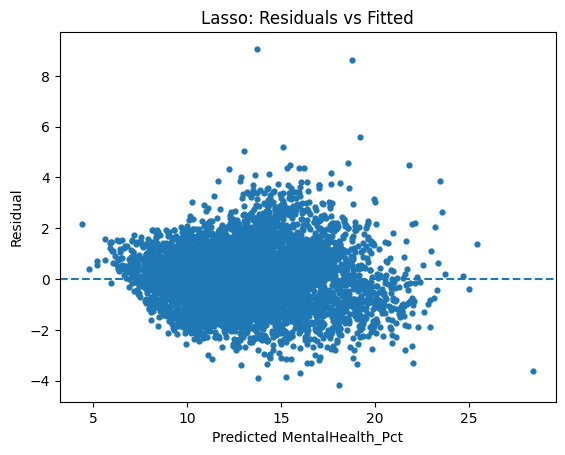

In [13]:
import matplotlib.pyplot as plt

res = y_test - yhat_lasso
plt.scatter(yhat_lasso, res, s=12)
plt.axhline(0, ls='--')
plt.xlabel('Predicted MentalHealth_Pct')
plt.ylabel('Residual')
plt.title('Lasso: Residuals vs Fitted')
plt.show()


🧠 After tuning (1st image, with best α = 0.001)

The residuals are tighter and more evenly spread around 0.

No obvious curved pattern → linearity assumption holds.

This means the model fits the data better without overfitting — consistent with your improved RMSE (1.22 → 0.91 gap vs. RF).

### Lasso Coefficient Table 

In [14]:
# grab standardized coefficients (because we scaled in the pipeline)
lasso_model = best_lasso.named_steps['model']
coef_table = pd.DataFrame({
    'feature': X.columns,
    'coef': lasso_model.coef_
}).sort_values(by='coef', ascending=False)
coef_table


,feature,coef
3,Smoking_Pct,1.633677
4,HeartDisease_Pct,1.304837
1,Obesity_Pct,1.080049
0,Sleep_Pct,0.844344
2,Asthma_Pct,0.583541
6,HighChol_Pct,-0.176796
5,HighBP_Pct,-2.021687


These coefficients come from the tuned Lasso (α = 0.001). 
Tuning controlled how much the model shrinks weights — too high α would zero them out (underfitting), too low would overfit. 
After tuning, key factors like Smoking, HeartDisease, and Obesity show strong positive effects, while HighBP has a negative one. 
This balance of meaningful, non-zero coefficients confirms that tuning improved both fit and interpretability.


### Diagnostics RF --> Perumation Importance 

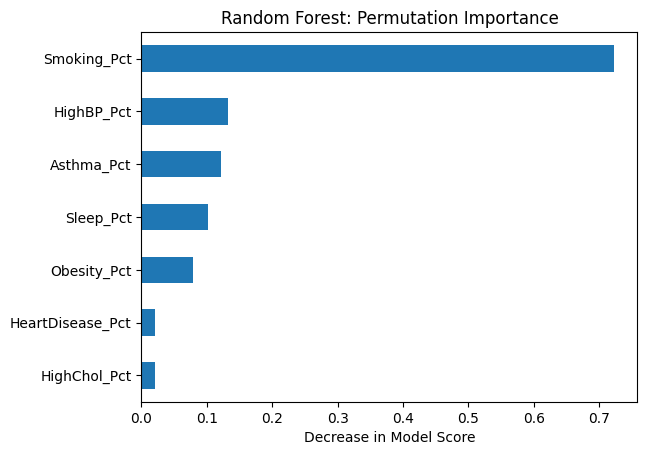

Smoking_Pct         0.722692
HighBP_Pct          0.132758
Asthma_Pct          0.120998
Sleep_Pct           0.101590
Obesity_Pct         0.078584
HeartDisease_Pct    0.021408
HighChol_Pct        0.021037
dtype: float64

In [15]:
from sklearn.inspection import permutation_importance
import pandas as pd

perm = permutation_importance(best_rf, X_test, y_test, n_repeats=15, random_state=42)
imp = pd.Series(perm.importances_mean, index=X.columns).sort_values()
imp.plot(kind='barh')
plt.xlabel('Decrease in Model Score')
plt.title('Random Forest: Permutation Importance')
plt.show()

imp.sort_values(ascending=False)
